### Matropolis-Hastings para remoção de ruído

O ruído é uma perturbação, degeneração ou poluição na imagem original. Nosso objetivo é, de alguma forma, restaurar o máximo que for possível do conteúdo original, removendo esses ruídos.
Nesse projeto em específico, é considerado o **Ising Model**, que modela situações onde temos dois estados (+1 e -1) que podem interagir com sua vizinhança. É assumido que a imagem em questão é passível de ser interpretada com esse modelo: se escolhermos, aleatoriamente, um pixel preto, há mais chances de que ele esteja cercado por outros pixels pretos (o mesmo para pixels brancos).

Consideramos então uma imagem $Z$ preta e branca, ou seja, $+1$ ou $-1$, que é o nosso objetivo. Temos uma outra imagem, $X$, que é $Z$ perturbada por ruídos.

De alguma forma, queremos partir de $X$ e chegar a $Z$. Para isso, é utilizado o algoritmo de **Metropolis-Hastings*:

1. Escolhemos um pixel aleatório de $X$;
2. Calculamos a probabilidade de aceitação em inverter esse pixel ou não;
3. Invertemos ou não esse pixel de acordo com a probabilidade obtida;
4. Repetimos esse processo até obtermos uma convergência.


### Metropolis-Hastings

Sabemos que a descrição elementar do algoritmo, fora do contexto de ruídos, é dada por:

Seja $\pi$ = ($\pi_1$, $\pi_2$, ...) uma distribuição de probabilidade discreta. Construiremos uma cadeia de Markov reversível $X_0, X_1, ...$ cuja distribuição estacionária é $\pi$.
Consideramos, ainda, $T$ uma matriz de transição para qualquer cadeia de Markov irredutível que possua o mesmo espaço de estados como $\pi$. Essa cadeia é uma *proposal chain*, gerando elementos de uma sequência que o algoritmo pode ou não decidir aceitar.
Se estamos em um estado $X_n$, o próximo estado $X_{n+1}$ é obtido da seguinte forma:

1. Escohemos um novo estado de acordo com $T$, ou seja, escolhemos o estado $j$ com probabilidade $T_{ij}$.
2. Decidimos de o estado $j$ é aceito ou não, a partir da *acceptance function*:
$$
a(i, j) = \frac{\pi_j T_{ji}}{\pi_i T_{ij}
$$
Se $a(i,j) \geq 1$, j é aceito como o próximo estado. Se $a(i,j) < 1$, j é aceito com probabilidade $a(i,j)$; se $j$ não é aceito, o próximo estado é igual ao estado atual.

### No contexto de ruídos

É trivial notar que nossa matriz é a próxima imagem $X$, e queremos chegar a uma matriz que é a imagem $Z$.
Consideremos $Z^{(t)}$ o estado da imagem $Z$ construída no instante $t$; o pixel $(i, j)$, escolhido aleatoriamente, pode ou não ser invertido, transicionando para $Z^{(t+1)}$
A acceptance function será:

\begin{eqnarray}
a(i, j)
& = &
\frac{p(Z^{(t+1)} | X, \beta, \pi)}{p(Z^{(t)} | X, \beta, \pi)} \\
& = &
\exp{\left( - 2\gamma Z^{(t)}_{ij} X_{ij} - 2\beta \sum_{(i,j) \sim (k,l)} Z^{(t)}_{ij} Z^{(t)}_{kl} \right)}
\end{eqnarray}

Se $a(i,j) \geq 1$, o pixel é invertido; se $a(i, j) < 1$, o pixel é invertido com probabilidade $a(i,j)$.

Observemos que
\begin{eqnarray}
p(Z \mid X, \beta, \pi)
& \propto & \exp{\left( \gamma \sum_{ij} Z_{ij} X_{ij} + \beta \sum_{(i,j)\sim (k,l)} Z_{ij} Z_{kl} \right)}
\end{eqnarray}

Onde $\gamma = \dfrac{1}{2} \log{\dfrac{1-\pi}{\pi}}$. Valores maiores de $\gamma$ significam poucos ruídos em $X$. Similarmente, esperamos maior consistência de vizinhança se $\beta$ grande (se um pixel é preto, é esperado que os vizinhos também sejam; o mesmo para os pixels brancos).

### Pseudocódigo

1. Initializamos $\beta$, $\pi$ e $\gamma$
2. Initializamos $Z^{(0)} \gets X$
3. A cada passo $t$:
    3.1. Escolhemos um pixel $(i,j)$ aleatoriamente.
    3.2. "Propomos" a inversão de pixel: $Z^{(t+1)}_{ij} \gets -Z^{(t)}_{ij} $.
    3.3. Calculamos a probabilidade de aceitação
    $\alpha(i, j) = \min\left\{ 1 , \frac{p(Z^{(t+1)} \mid X, \beta, \pi)}{p(Z^{(t)} \mid X, \beta, \pi)} \right\}$
    3.4. $Z^{(t+1)}_{ij} \gets -Z^{(t)}_{ij}$ com probabilidade $\alpha(i,j)$
    3.5. $Z^{(t+1)}_{ij} \gets Z^{(t)}_{ij}$, se 3.4 não foi aceito

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from pylab import rcParams

rcParams['figure.figsize'] = 6, 6

In [ ]:
# carregando a mostrando a imagem com ruído
X = np.loadtxt("./figures/lena_noisy.txt")
plt.imshow(X,cmap='gray',vmin=-1,vmax=1)
plt.show()


In [ ]:
X # os valores dos pixels da imagem com ruído

#### O algoritmo em si

In [ ]:
def calculate_mcmc(beta: float, pi: float, gamma: float, T: int):
    Z = X.copy() # Initialize Z from X
    I, J = Z.shape
    for t in range(T):
        i,j = np.random.choice(I), np.random.choice(J) # randomly choose a coordinate (i,j)

        # Calculate acceptance propability
        # We don't take exponential. Instead, we take the log of random number. This is more stable.
        delta_E = -2*gamma*X[i,j]*Z[i,j] -2*beta*Z[i,j]*(np.sum(Z[max(i-1,0):i+2,max(j-1,0):j+2]) - Z[i,j])

        # We also don't deal with minimum function for acceptance probability
        #   because we don't need to cast it to 1 if it is higher.

        # Flip the pixel if accepted
        if np.log(np.random.rand()) < delta_E:
            Z[i,j] = - Z[i,j] # Update the image

    fig, ax = plt.subplots(1,2, figsize=(16,8))
    ax[0].imshow(X,cmap='gray',vmin=-1,vmax=1)
    ax[0].set_title("Noisy", fontsize=16)
    ax[1].imshow(Z,cmap='gray',vmin=-1,vmax=1)
    ax[1].set_title("Denoised", fontsize=16)
    plt.show()

#### Alguns exemplos de resultados, variando os parâmetros

In [ ]:
beta, pi  = 0.8, 0.15 # for arbitrary parameters that reflects our prior belief
gamma = 0.5*np.log((1-pi)/pi)
T = 5000000 # sufficient number of steps to converge stationary distribution

calculate_mcmc(beta, pi, gamma, T)


In [ ]:
beta, pi  = 0.5, 0.3 # for arbitrary parameters that reflects our prior belief
gamma = 0.5*np.log((1-pi)/pi)
T = 5000000 # sufficient number of steps to converge stationary distribution

calculate_mcmc(beta, pi, gamma, T)


In [ ]:
beta, pi  = 0.95, 0.1 # for arbitrary parameters that reflects our prior belief
gamma = 0.5*np.log((1-pi)/pi)
T = 5000000 # sufficient number of steps to converge stationary distribution

calculate_mcmc(beta, pi, gamma, T)


In [ ]:
beta, pi  = -0.8, 0.15 # for arbitrary parameters that reflects our prior belief
gamma = 0.5*np.log((1-pi)/pi)
T = 5000000 # sufficient number of steps to converge stationary distribution

calculate_mcmc(beta, pi, gamma, T)


In [ ]:

beta, pi = -0.1, 0.15  # for arbitrary parameters that reflects our prior belief
gamma = 0.5 * np.log((1 - pi) / pi)
T = 5000000  # sufficient number of steps to converge stationary distribution

calculate_mcmc(beta, pi, gamma, T)


In [ ]:

beta, pi = 1.1, 0.15  # for arbitrary parameters that reflects our prior belief
gamma = 0.5 * np.log((1 - pi) / pi)
T = 5000000  # sufficient number of steps to converge stationary distribution

calculate_mcmc(beta, pi, gamma, T)


### Algoritmo de Gibbs para remoção de ruídos


A linguagem matemática utilizada no livro torna um pouco confuso o entendimento, dado que a linguagem utilizada nos exemplos utiliza diferentes letras e nomes. Foquemos no que foi visto até o momento.

Temos um grafo (podendo também ser visualizado como uma matriz), no qual cada vértice/elemento $ij$ possui um valor $+1$ ou $-1$; cada vértice está conectado com outros $4$ vértices vizinhos, com exceção das margens. No contexto de imagens, temos uma imagem $X$ com ruído, e nosso objetivo é encontrar a imagem $Z$ original, que nos é desconhecida; valendo ainda os conceitos de $+1$ e $-1$ para pixels pretos e brancos, respectivamente.

Essa remoção de ruído pode ser vista como uma estimativa máxima a posteriori da distribuição $P(Z|X)$. Pelo Teorema de Bayes, temos que $P(Z|X) = \frac{P(X|Z)P(Z)}{P(X)}$, podendo ser reescrito no espaço logarítmico:

$$
$\log{P(Z|X)} = \log{P(X|Z)} + \log{P(Z)} - \log{P(X)}$
$$

Como $X$ é conhecido, basta minimizarmos $- \log{P(X|Z)} - \log{P(Z)}$

Pela definição da entrada do algoritmo, podemos considerar que cada pixel $Z_{ij}$ está conectado com 4 vizinhos, adicionalmente de um elemento $X_{ij}$, que é o ruído. Dados esses vizinhos, podemos determinar a distribuição de $Z_{ij}$; as bordas não possuem essa quantidade, mas adicionamos "vizinhos nulos" para uma maior facilidade na implementação.

Então para calcular, por exemplo, a probabilidade de $Z_{ij} = +1$ (ser preto), temos:
$$
P(Z_{ij} = +1 | X) = \frac{1}{k}exp(\alpha \sum_{i} \sum_{j} X_{ij}Z_{ij} + \beta \sum_{i'j' \in N(ij)} Z_{ij}Z_{i'j'})
$$
Onde $k$ é a constante de normalização, $\alpha$ e $\beta$ são os hiperparâmetros e $N(ij$) são os vizinhos de $Z_{ij}$ diferentes de $X_{ij}$

Já aplicando no espaço logarítmico, temos:
$$
-\log{P(X|Z)} - \log{P(Z)} = -\alpha \sum_{i} \sum_{j} X_{ij}Z_{ij} - \beta \sum_{i'j' \in N(ij)} Z_{ij}Z_{i'j'}
$$

Pelo Teorema de Bayes, podemos derivar que:
$$
P(Z_{ij} = +1 | Z_{N(i,j)}, X_{ij}) = \frac{1}{1 + exp(-2 \alpha X_{ij} + \beta \sum_{N(ij)} Z_{N(ij)})
$$

- $Z_{ij}$: pixel $ij$;
- $Z_{N(i,j)}$: vizinhos de $Z_{ij}$, diferentes de $X_{ij}$;
- $X_{ij}$: pixel $ij$ da imagem com ruído.

#### Pseudocódigo para o algoritmo de Gibbs:

1. Inicializamos $Z$ de forma aleatória, com o mesmo shape de $X$;
2. Inicializamos $T$ como uma matriz de $0's$ # ela guardará as probabilidades a posteriori
3. totalsamples $\gets$ número de amostras que queremos simular
4. burn_in steps $\gets$ número mínimo para considerarmos que a cadeia convergiu
5. Para cada passo $t$:
    Para cada $Z_{ij}$ em $Z$:
        - Amostre $Z_{ij}$ baseado em $P(Z_{ij} | Z_{N(i,j)}, X_{ij})$
        - Atualize o valor de $Z_{ij}$
        - Se $t >$ burn in steps e $Z_{ij} = 1$, então $T_{ij} \gets T_{ij} + 1$
6. $T \gets T / totalsamples$ # normalizando
7. $Z \gets$ matriz de elementos iguais a $-1$
8. Para cada $T_{ij}$:
    Se $T_{ij} > p$, então $Z_{ij} \gets +1$ # onde $p$ é uma probabilidade mínima
9. Retorne $Z$ # que é a imagem sem ruído

Em alguns casos, é possível utilizar uma probabilidade de aceitação é sempre $1$, incorporando-a dentro da matriz de proposta:

- Geramos uma proposta $j$;
- Calculamos a probabilidade de aceitação $a(i,j)$;
- Incorporamos essa probabilidade na matriz: $T_{ij} = \gets a(i,j)T_{ij}$
- Aceitamos a proposta com probabilidade $1$, já que ela já foi incorporada na matriz de proposta.


Apesar de se proporem a resolver um mesmo problema, e fazerem isso com eficiência (vide os exemplos dos links), elas são soluções diferentes, ainda que sejam parecidas. O algoritmo de Gibbs atualiza cada pixel condicionalmente aos pixels vizinhos, não envolvendo uma probabilidade de aceitação; não há a etapa probabilística de aceitação ou rejeição, como utilizada no Metropolis-Hastings.


### Criptografia


Consideramos apenas o caso trivial em que um texto é criptografado utilizando uma função que mapeia uma letra do alfabeto para outra letra do alfabeto. A implementação consiste em um passeio aleatório em um conjunto de funções de encoding: dado $f$, a função de proposta $f*$ é gerada escolhendo-se duas letras do alfabeto aleatoriamente e trocando seus valores mapeados em $f$.

Temos:

1. Inicialize com uma função de encoding $f$, por simplicidade escolhida como a função identidade.
2. Selecione duas letras aleatoriamente de forma uniforme e troque entre si os valores que $f$ mapeia para essas letras, obtendo uma proposta $f*$;
3. Calcule a função de aceitação $a(f, f*) = \frac{score(f*)}{score(f)}$
4. Considere $U$ uniformemente distribuída em $(0, 1)$. Se $U \leq a(f,f*)$, $f*$ é aceita; se não, permanecemos com $f$.

Onde o $score$ de uma função $f$ é o produto de todos os pares de letras sucessivos no texto "de treinamento" $f(c_i), f(c_{i+1})$, $c_i$ é uma letra na posição $i$ em um texto.

A mensagem criptografada do exemplo do livro possui $320$  letras, ou seja, temos $(c_1, ..., c_{320})$. O score é dado por:
$$
score(f) = \prod_{i=1}^{319} M_{f(c_i),f(c_{i+1})}
$$

$M$ é a matriz de transição, indexada por $(a,b,...,z,[espaço])$

Após um número grande de iterações, a função obtida conseguirá resgatar a mensagem original, mapeando corretamente cada letra da mensagem criptografada para a letra do texto verdadeiro.

### MCMC contínuo


O comprimento do intervalo de distribuição é importante para a convergência e para a eficiência de amostragens: ele afeta diretamente a quantidade de propostas aceitas.

Se o comprimento do intervalo de distribuição for muito pequeno, as propostas geradas podem não explorar e amostrar totalmente o espaço amostral, dado que o algoritmo pode ter uma taxa de aceitação baixa, devido à baixa probabilidade de aceitação; além de uma convergência lenta.

Se o comprimento do intervalo de distribuição for muito grande, as propostas geradas podem ser aceitas com mais frequência do que o ideal, levando a amostragens com espaçamento muito grande do espaço amostral, tornando a exploração da distribuição incompleta e enviesada.

#### Algoritmo como descrito no livro, com intervalo $2$

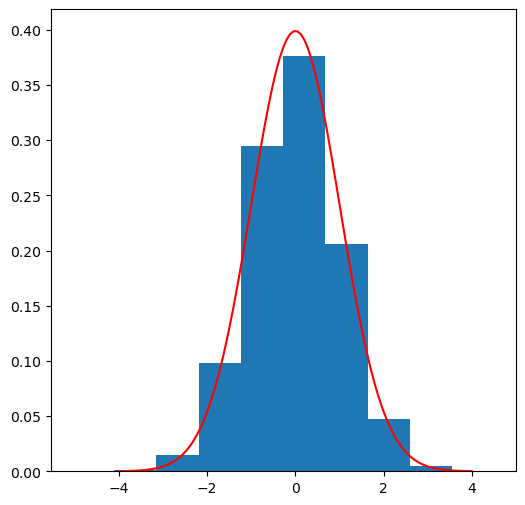

In [33]:
import numpy as np
import matplotlib.pyplot as plt

trials = 1000000
simlist = np.zeros(trials)
state = 0

for i in range(2, trials):
    prop = np.random.uniform(state - 1, state + 1)
    acc = np.exp(-((prop ** 2 - state ** 2) / 2))

    if np.random.uniform() < acc:
        state = prop

    simlist[i] = state

plt.hist(simlist, density=True)
plt.xlabel("")
plt.title("")
plt.plot(np.linspace(-4, 4, 100), np.exp(-np.linspace(-4, 4, 100) ** 2 / 2) / np.sqrt(2 * np.pi), 'r')
plt.show()

#### Alterando o intervalo para $0.02$

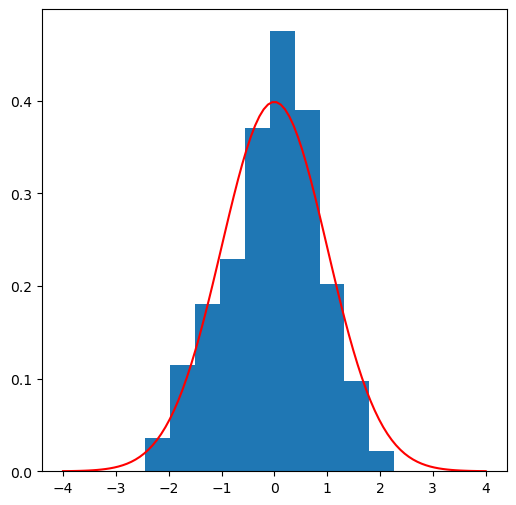

In [36]:
import numpy as np
import matplotlib.pyplot as plt

trials = 1000000
simlist = np.zeros(trials)
state = 0

for i in range(2, trials):
    prop = np.random.uniform(state - 0.01, state + 0.01)
    acc = np.exp(-((prop ** 2 - state ** 2) / 2))

    if np.random.uniform() < acc:
        state = prop

    simlist[i] = state

plt.hist(simlist, density=True)
plt.xlabel("")
plt.title("")
plt.plot(np.linspace(-4, 4, 100), np.exp(-np.linspace(-4, 4, 100) ** 2 / 2) / np.sqrt(2 * np.pi), 'r')
plt.show()


#### Alterando o intervalo para $100$.

Podemos notar que a distribuição normal padrão é um caso especial que não é drasticamente afetado. O mesmo resultado é obtido para quaisquer valores de comprimento do intervalo.

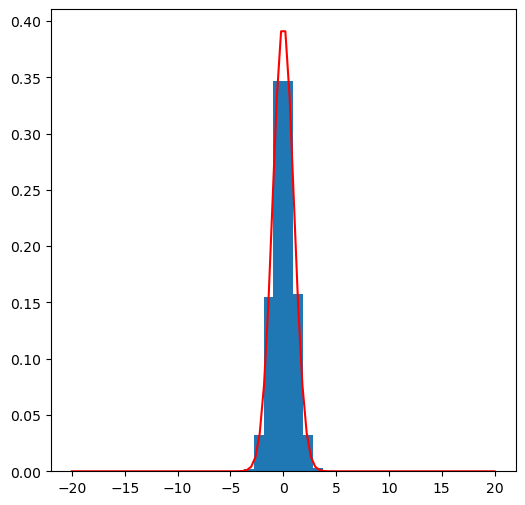

In [48]:
import numpy as np
import matplotlib.pyplot as plt

trials = 1000000
simlist = np.zeros(trials)
state = 0

for i in range(2, trials):
    prop = np.random.uniform(state - 50.0, state + 50.0)
    acc = np.exp(-((prop ** 2 - state ** 2) / 2))

    if np.random.uniform() < acc:
        state = prop

    simlist[i] = state

plt.hist(simlist, density=True)
plt.xlabel("")
plt.title("")
plt.plot(np.linspace(-20, 20, 100), np.exp(-np.linspace(-20, 20, 100) ** 2 / 2) / np.sqrt(2 * np.pi), 'r')
plt.show()


Explique como funciona o método de MCMC para tirar amostras de uma variável Gaussiana: qual o papel do estado atual no algoritmo? Qual a adaptação que foi feita no algoritmo MCMC para que ele consiga tirar amostras de distribuições contínuas ao invés de discretas?

No MCMC contínuo, a distribuição $\pi$ é uma função densidade de probabilidade, e a transição é dada por uma *função de transição*, ao invés de uma matriz de transição, onde $P_{ij}$ é o valor da função densidade condicionado a $X_0 = i$

O estado atual é de suma importância pois é a partir dele que iremos propor outro estado: a cada iteração, o algoritmo propõe um novo estado com base no estado atual; essa proposta é calculada a partir de uma distribuição de proposta, que nesse caso é uma distribuição uniforme centrada no estado atual. Calculamos então a aceitação e a usamos para aceitar ou rejeitar esse novo estado proposto.

A adaptação feita foi a possibilidade de distribuições contínuas nas propostas de transição, que é o caso do exemplo do livro.

#### Amostras de uma outra distribuição

A função densidade de probabilidade da distribuição dada é:

$f(\rho) = \frac{\rho^y (1-\rho)^n}{K}$, se $0 < \rho < 1$
$f(\rho) = 0$ se $\rho \leq 0$ ou $\rho \geq 1$


In [61]:
import numpy as np
import matplotlib.pyplot as plt

def sample(y: float, n: float, K: float = 1.0):
    """
    :param y: Constante dada pelo usuário.
    :param n: Constante dada pelo usuário.
    :param K: Constante a ser calculada.
    """

    trials = 1000000
    simlist = np.zeros(trials)
    state = 0.5

    for i in range(2, trials):
        prop = np.random.uniform(state - 0.3, state + 0.3) # deixando o comprimento igual a 0.6
        acc = (np.power(prop, y) * np.power(1-prop, n) / K) / (np.power(state, y) * np.power(1-state, n) / K)

        if np.random.uniform() < acc:
            state = prop

        simlist[i] = state

    plt.hist(simlist, density=True)
    plt.xlabel("")
    plt.title("")
    plt.show()


/tmp/ipykernel_12008/2869188889.py:17: RuntimeWarning: invalid value encountered in power
  acc = (np.power(prop, y) * np.power(1-prop, n) / K) / (np.power(state, y) * np.power(1-state, n) / K)


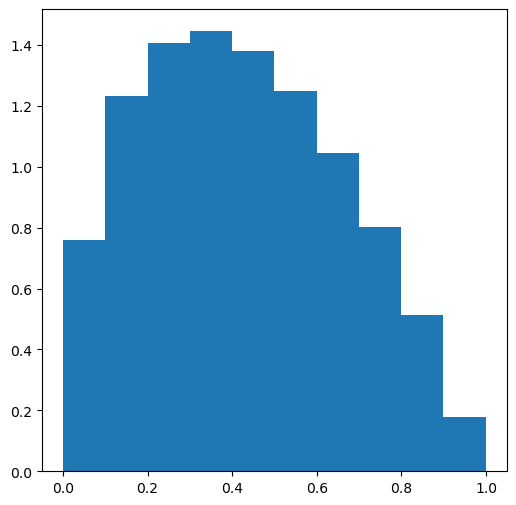

In [62]:
# valores arbitrários
sample(y=0.5, n=1.0)